# Labs Access Analysis: 03 City Map Plot

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import json
pd.options.mode.chained_assignment = None
import branca.colormap as cmp
import os
import time
import folium
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore') # ignore warnings

# Change the font
sns.set_context("poster", font_scale=1.5)
sns.set_style(style="whitegrid")
matplotlib.rc('font', family='serif', serif='Fira Sans')

In [2]:
url_data_labs = "data/labs.csv"
url_data_isochrones = "data/isochrones.json"

In [3]:
# Load data, json
with open(url_data_isochrones) as json_file:
    data = json.load(json_file)

In [4]:
# Load data, csv
labs = pd.read_csv(url_data_labs)

In [5]:
locations = {}
for i in data:
  locations[i['name']] = i['metadata']['query']['locations'][0]

### Select only City labs, not the full Metropolitan Area

In [6]:
searchfor = ['Barcelona', 'Milan']
city_labs = labs[labs.City.str.contains('|'.join(searchfor))]

In [7]:
city_labs.head()

Name     Type       City Cluster  \
0          Fab Lab Barcelona  Fab Lab  Barcelona     BCN   
1  MADE Makerspace Barcelona  Fab Lab  Barcelona     BCN   
2                  Soko Tech  Fab Lab  Barcelona     BCN   
3                  LSCongres  Fab Lab  Barcelona     BCN   
5     Barcelona Mobility LAB  Fab Lab  Barcelona     BCN   

                                  Address     CAP        Lat      Long  \
0                  Carrer de Pujades, 102  8005.0  41.396925  2.194335   
1          Carrer Noguera Pallaresa 59-61  8014.0  41.373238  2.141084   
2            Carrer de Vallès i Ribot, 36  8027.0  41.424535  2.188883   
3      Carrer del Cardenal Tedeschini, 50  8027.0  41.426002  2.182026   
5  Passatge del Torrent de l'Estadella 56  8030.0  41.432152  2.199793   

                                              Source  \
0                                         Fablabs.io   
1  Fablabs.io, Hackerspaces.org, Makerspaces.make.co   
2                                         Fablabs.io   
3                                         Fablabs.io   
5                                         Fablabs.io   

                                 URL Notes  
0             https://fablabbcn.org/   NaN  
1                                NaN   NaN  
2                 https://soko.tech/   NaN  
3  https://fablabs.io/labs/lscongres   NaN  
5                                NaN   NaN

In [8]:
closed_labs = city_labs[city_labs.Notes.str.contains("losed")==True]
city_labs = city_labs[~city_labs.index.isin(closed_labs.index)]

In [9]:
locations = {}
for i in data:
    if (i['name'] in city_labs["Name"].values):
        locations[i['name']] = i['metadata']['query']['locations'][0]

In [10]:
# Remove the metropolital labs from the isochrones data
for i in data:
    if (i['name'] not in city_labs["Name"].values):
        print("Removed",i['name'])
        data.remove(i)
        
# One lab is not removed at first iteration??
for i in data:
    if (i['name'] not in city_labs["Name"].values):
        print("Removed",i['name'])
        data.remove(i)

Removed Green Fab Lab
Removed Fab Lab Sant Cugat
Removed Multilab Rozzano
Removed W!LAB
Removed Disseny Lab UAB
Removed BDN Lab
Removed EspluLab
Removed HP 3D Printing and Digital Manufacturing Center of Excellence
Removed Fab Lab Tinkerers


### Map visualziation

In [11]:
m=folium.Map(location=[41.396721,2.1943200000000003])
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)

In [12]:
for loc in locations:
  folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(m)

In [13]:
m

organize the data

In [14]:
rows = []
for h in data:
  rows.append([h["name"], h["features"][0]["properties"]["total_pop"], h["features"][0]["properties"]["area"], h["features"][0]["properties"]["reachfactor"], h["features"][0]["geometry"]["coordinates"], []])

In [15]:
map_data = pd.DataFrame(rows, columns=['Name', 'total_pop', 'area', 'reachfactor','geometry', 'isochrone'])
map_data.head()

Name  total_pop        area  reachfactor  \
0          Fab Lab Barcelona    90862.0  4444783.82       0.9055   
1  MADE Makerspace Barcelona    87403.0  4378946.71       0.8921   
2                  Soko Tech    91433.0  4353937.57       0.8870   
3                  LSCongres    95371.0  4497971.38       0.9163   
4     Barcelona Mobility LAB    14029.0   663848.58       0.1352   

                                            geometry isochrone  
0  [[[2.181516, 41.395308], [2.181969, 41.39116],...        []  
1  [[[2.127469, 41.374827], [2.128559, 41.368987]...        []  
2  [[[2.174851, 41.424714], [2.174888, 41.423775]...        []  
3  [[[2.167014, 41.427727], [2.16735, 41.426536],...        []  
4  [[[2.194385, 41.435171], [2.194398, 41.435131]...        []

create a flip isochrone cell for each lab

In [16]:
for ind in map_data.index:
     row_iso = []
     for coords in map_data['geometry'][ind][0]:
       row_iso.append([coords[1], coords[0], 900])
     map_data.at[ind, 'isochrone'] = row_iso

In [17]:
map_data.set_index('Name', inplace=True)
labs.set_index('Name', inplace=True)

add colums from the csv file (the labs) to the json file (the isochrones)

In [18]:
full_map_data = map_data.join(labs)

In [19]:
full_map_data

total_pop        area  \
Name                                                                        
Fab Lab Barcelona                                     90862.0  4444783.82   
MADE Makerspace Barcelona                             87403.0  4378946.71   
Soko Tech                                             91433.0  4353937.57   
LSCongres                                             95371.0  4497971.38   
Barcelona Mobility LAB                                14029.0   663848.58   
The FabLab: Make in Milano                            40656.0  3753146.09   
Vectorealism FabLab                                   25520.0  2833731.26   
DamASpace                                             58690.0  4808370.81   
Miocugino - officina di gesta e ingegno               39458.0  3803092.83   
Opendot                                               56951.0  4261112.70   
Polifactory                                           30621.0  3349133.80   
WeMake | Makerspace Fablab                            40222.0  2986932.04   
FabLab Ventura                                        23228.0  3911166.12   
FabLabMilano - Fare le Idee                           23848.0  2591210.54   
Politecnico Open unix Labs                            61851.0  3933257.70   
Danaus                                               100054.0  4821324.40   
AKASHA Hub Barcelona                                  96774.0  4579290.88   
DIY Bio Barcelona                                     99832.0  4530756.47   
Maker Convent                                         87482.0  4390605.44   
Ateneu de Fabricació Les Corts                        88373.0  4220193.84   
Ateneu de Fabricació La Fàbrica del Sol               47179.0  2690404.47   
Ateneu de Fabricació Ciutat Meridiana                 11587.0  1595239.83   
Ateneu de Fabricació Parc Tecnológic                  83897.0  4256092.38   
Ateneu de Fabricació Gràcia                           97329.0  4525925.43   
Ateneu de Fabricació Ca L'Alier                       93219.0  4520821.81   
Punt Multimedia FAB Casa del Mig                      91882.0  4322193.87   
Punt Multimedia La Marina                             65902.0  3656017.38   
Club Maker de l'American Space - Biblioteca Fab...    86930.0  4165421.97   
Makers Zone BCN                                       86670.0  4483144.57   
FabCafé Barcelona                                     89397.0  4435223.24   
TMDC                                                  60612.0  3168386.09   
ATTA33                                                94386.0  4683626.94   
Kinlab                                                50314.0  4262958.08   
SuperForma                                            57463.0  4482719.37   
Makers Hub                                            20545.0  3117753.33   
Milano Luiss Hub                                      46495.0  4302234.15   
YATTA                                                 40301.0  3704286.47   
RavalFab / Colectic                                  101992.0  4732586.13   
IED Maker Lab                                         90686.0  4441082.75   
Punt Òmnia Casal Cívic Barcelona - Verdum - Fun...    69354.0  3782752.67   
IAM3DHUB / Dfactory Barcelona                         28808.0  1150407.81   
Locanda Officina Monumentale                          33427.0  2533030.57   
Ideas Bit Factory                                     33088.0  3803687.56   
Share Makerspace                                      11656.0  2355878.41   
Recipient                                             30996.0  3294317.37   
Camins Makers                                         61277.0  3549940.14   
Racó.net del Guinardó                                 91676.0  4589406.00   
Espai Jove Casa Sagnier                               94316.0  4550876.24   
EASD Llotja - Sant Andreu                             80707.0  3698951.82   
Canodrom                                              95440.0  4447291.38   
Cibernàrium Nou Barris                          

Transform the areas in square km


In [20]:
map_data["area"] = map_data["area"] / 1000000.0

In [21]:
map_data["area"].head()

Name
Fab Lab Barcelona            4.444784
MADE Makerspace Barcelona    4.378947
Soko Tech                    4.353938
LSCongres                    4.497971
Barcelona Mobility LAB       0.663849
Name: area, dtype: float64

### Population reached

plot the data

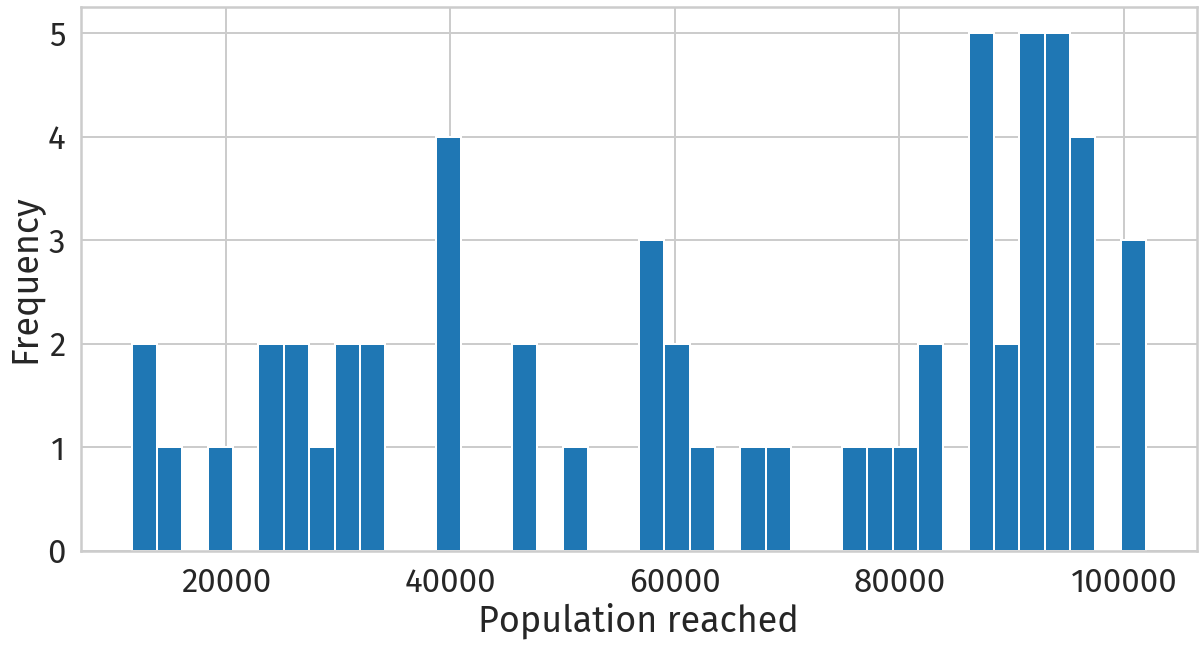

In [22]:
map_data["total_pop"].plot(kind="hist", bins=40, figsize=(20,10))
plt.xlabel('Population reached')
plt.savefig("svg" + os.sep + "city_labs_population_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_hist.png", dpi=300, bbox_inches="tight")

plot the data of the population reached by each lab

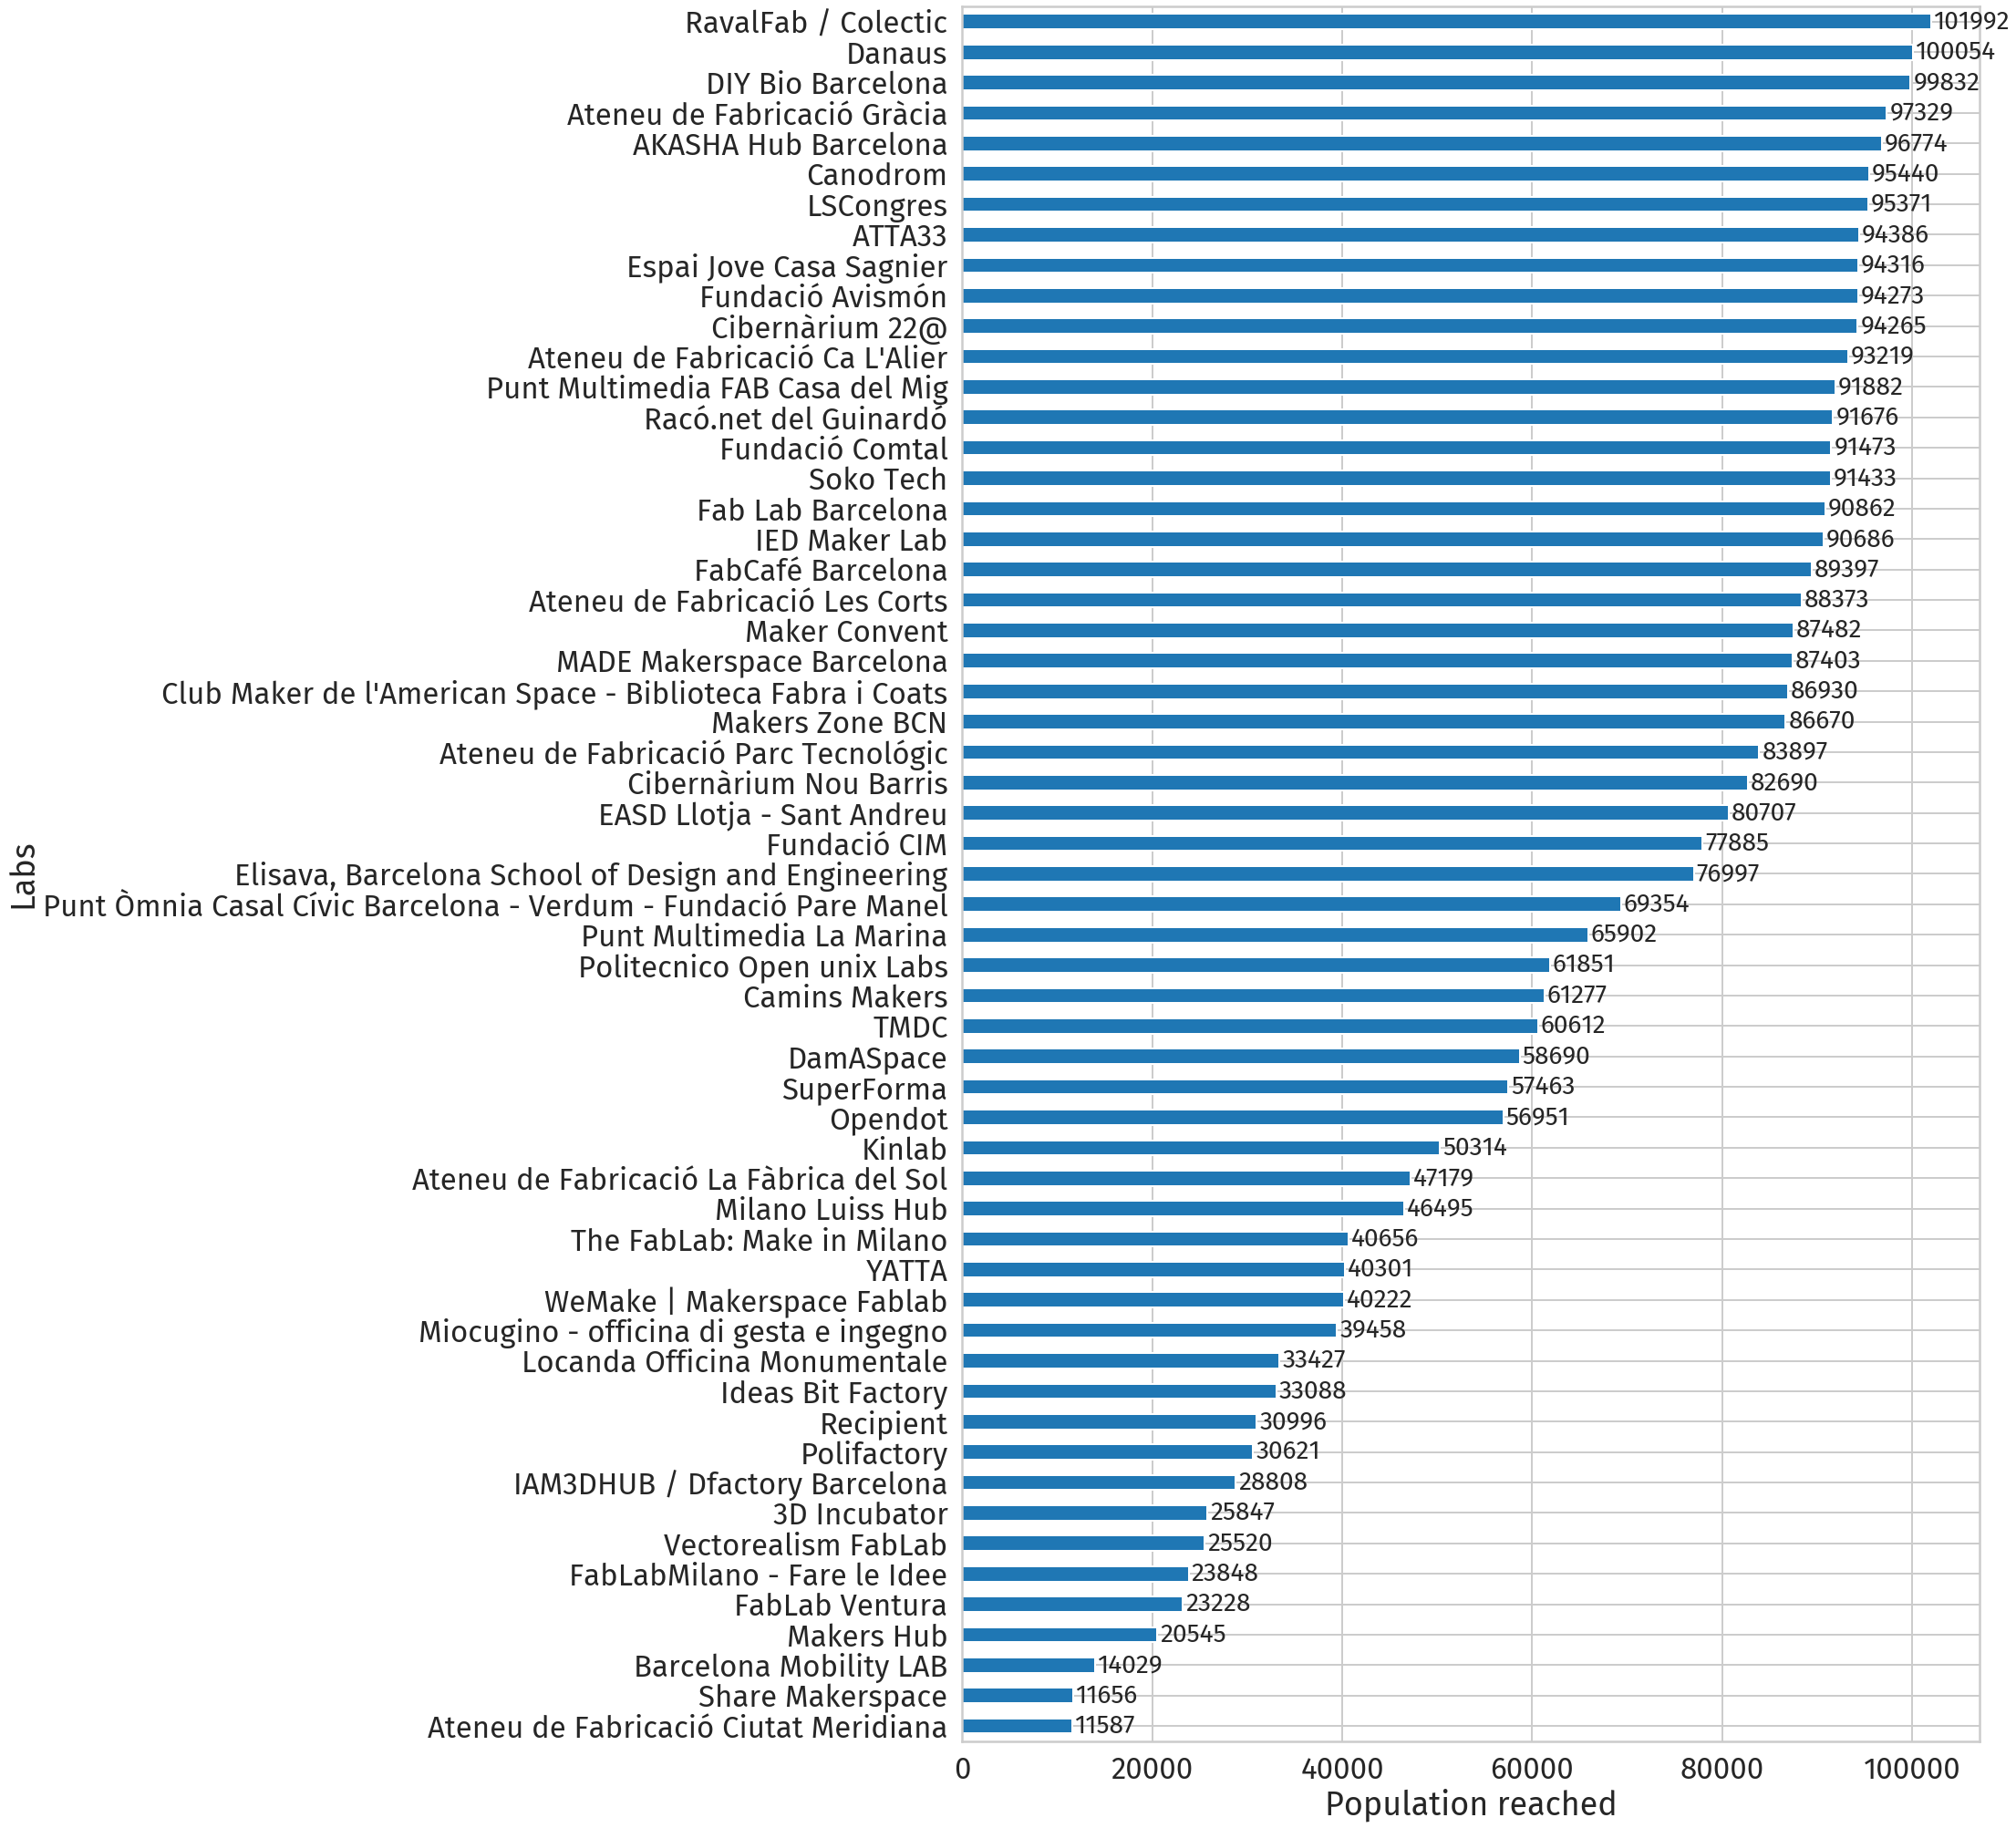

In [23]:
ax = map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind="barh", figsize=(20,35))
ax.bar_label(ax.containers[0], fmt="%d", size=28, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_population_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_bar.png", dpi=300, bbox_inches="tight")

### Area reached

Plot the data

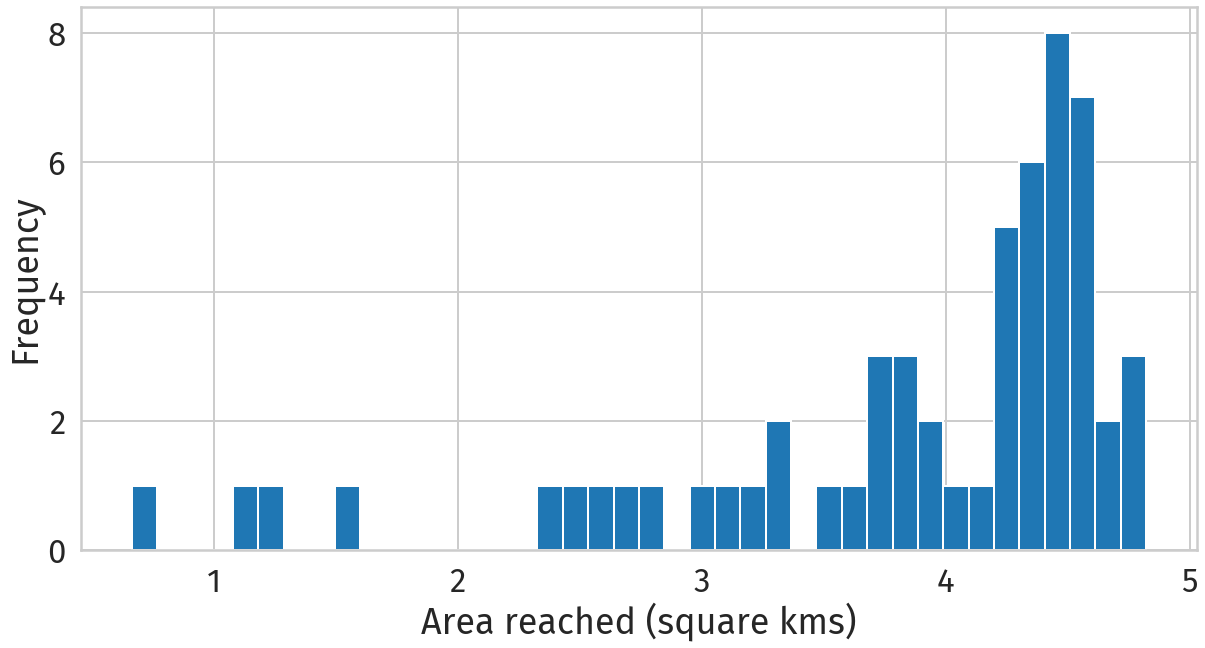

In [24]:
map_data["area"].plot(kind="hist", bins=40, figsize=(20,10))
plt.xlabel('Area reached (square kms)')
plt.savefig("svg" + os.sep + "city_labs_area_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_hist.png", dpi=300, bbox_inches="tight")

Plot the data of the area reached by each lab

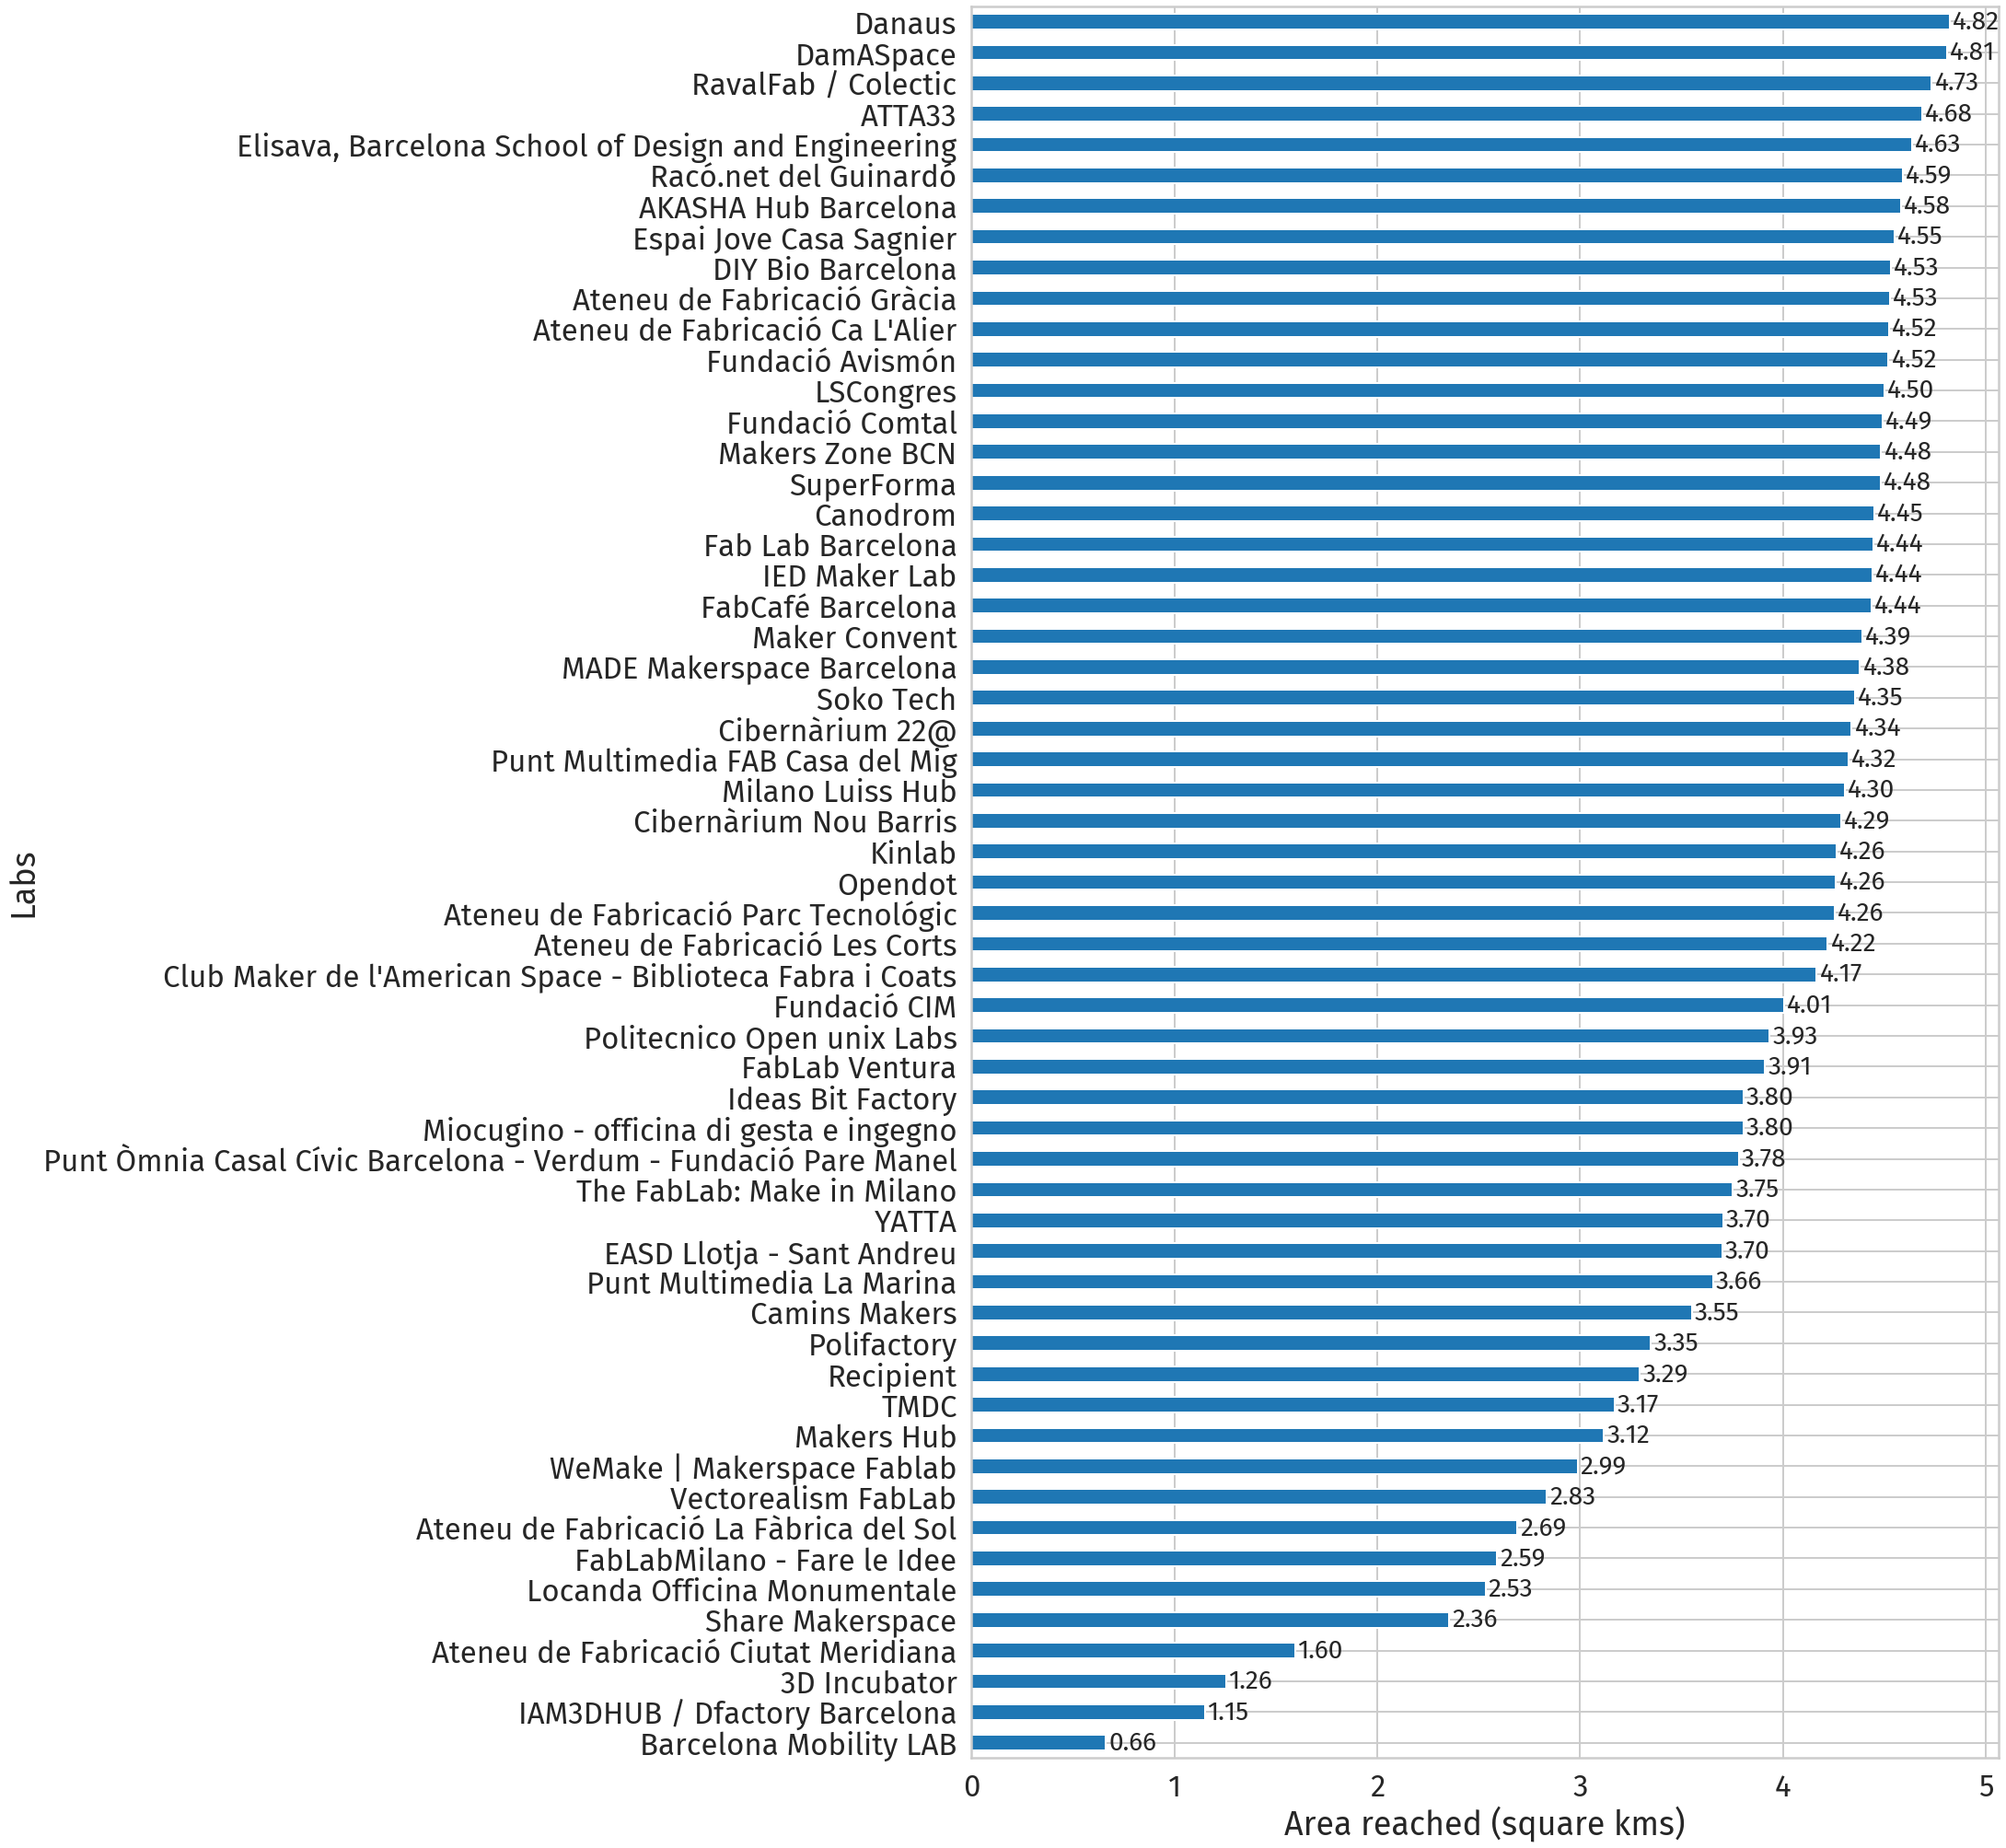

In [25]:
ax = map_data.sort_values(by=['area'])['area'].plot(kind="barh", figsize=(20,35))
ax.bar_label(ax.containers[0], fmt="%.2f", size=28, padding=3)
plt.xlabel('Area reached (square kms)')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_area_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_bar.png", dpi=300, bbox_inches="tight")

### Reach Factor

Plot the data

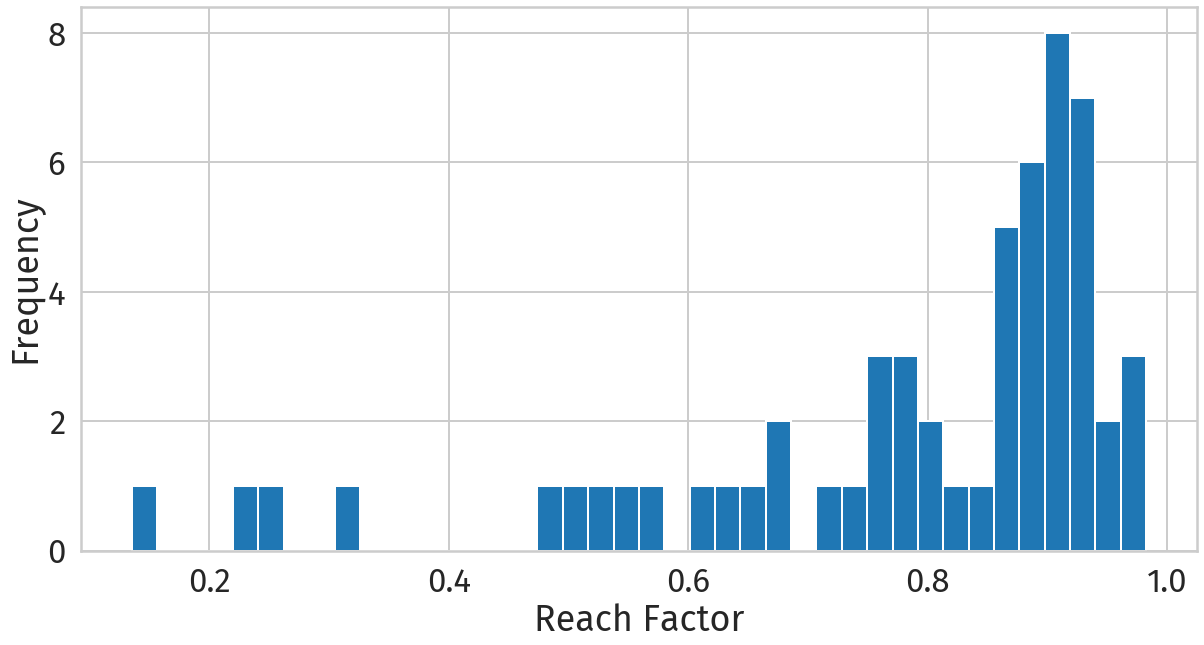

In [26]:
map_data["reachfactor"].plot(kind="hist", bins=40, figsize=(20,10))
plt.xlabel('Reach Factor')
plt.savefig("svg" + os.sep + "city_labs_reachfactor_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_hist.png", dpi=300, bbox_inches="tight")

plot the data of the reach factor for each lab

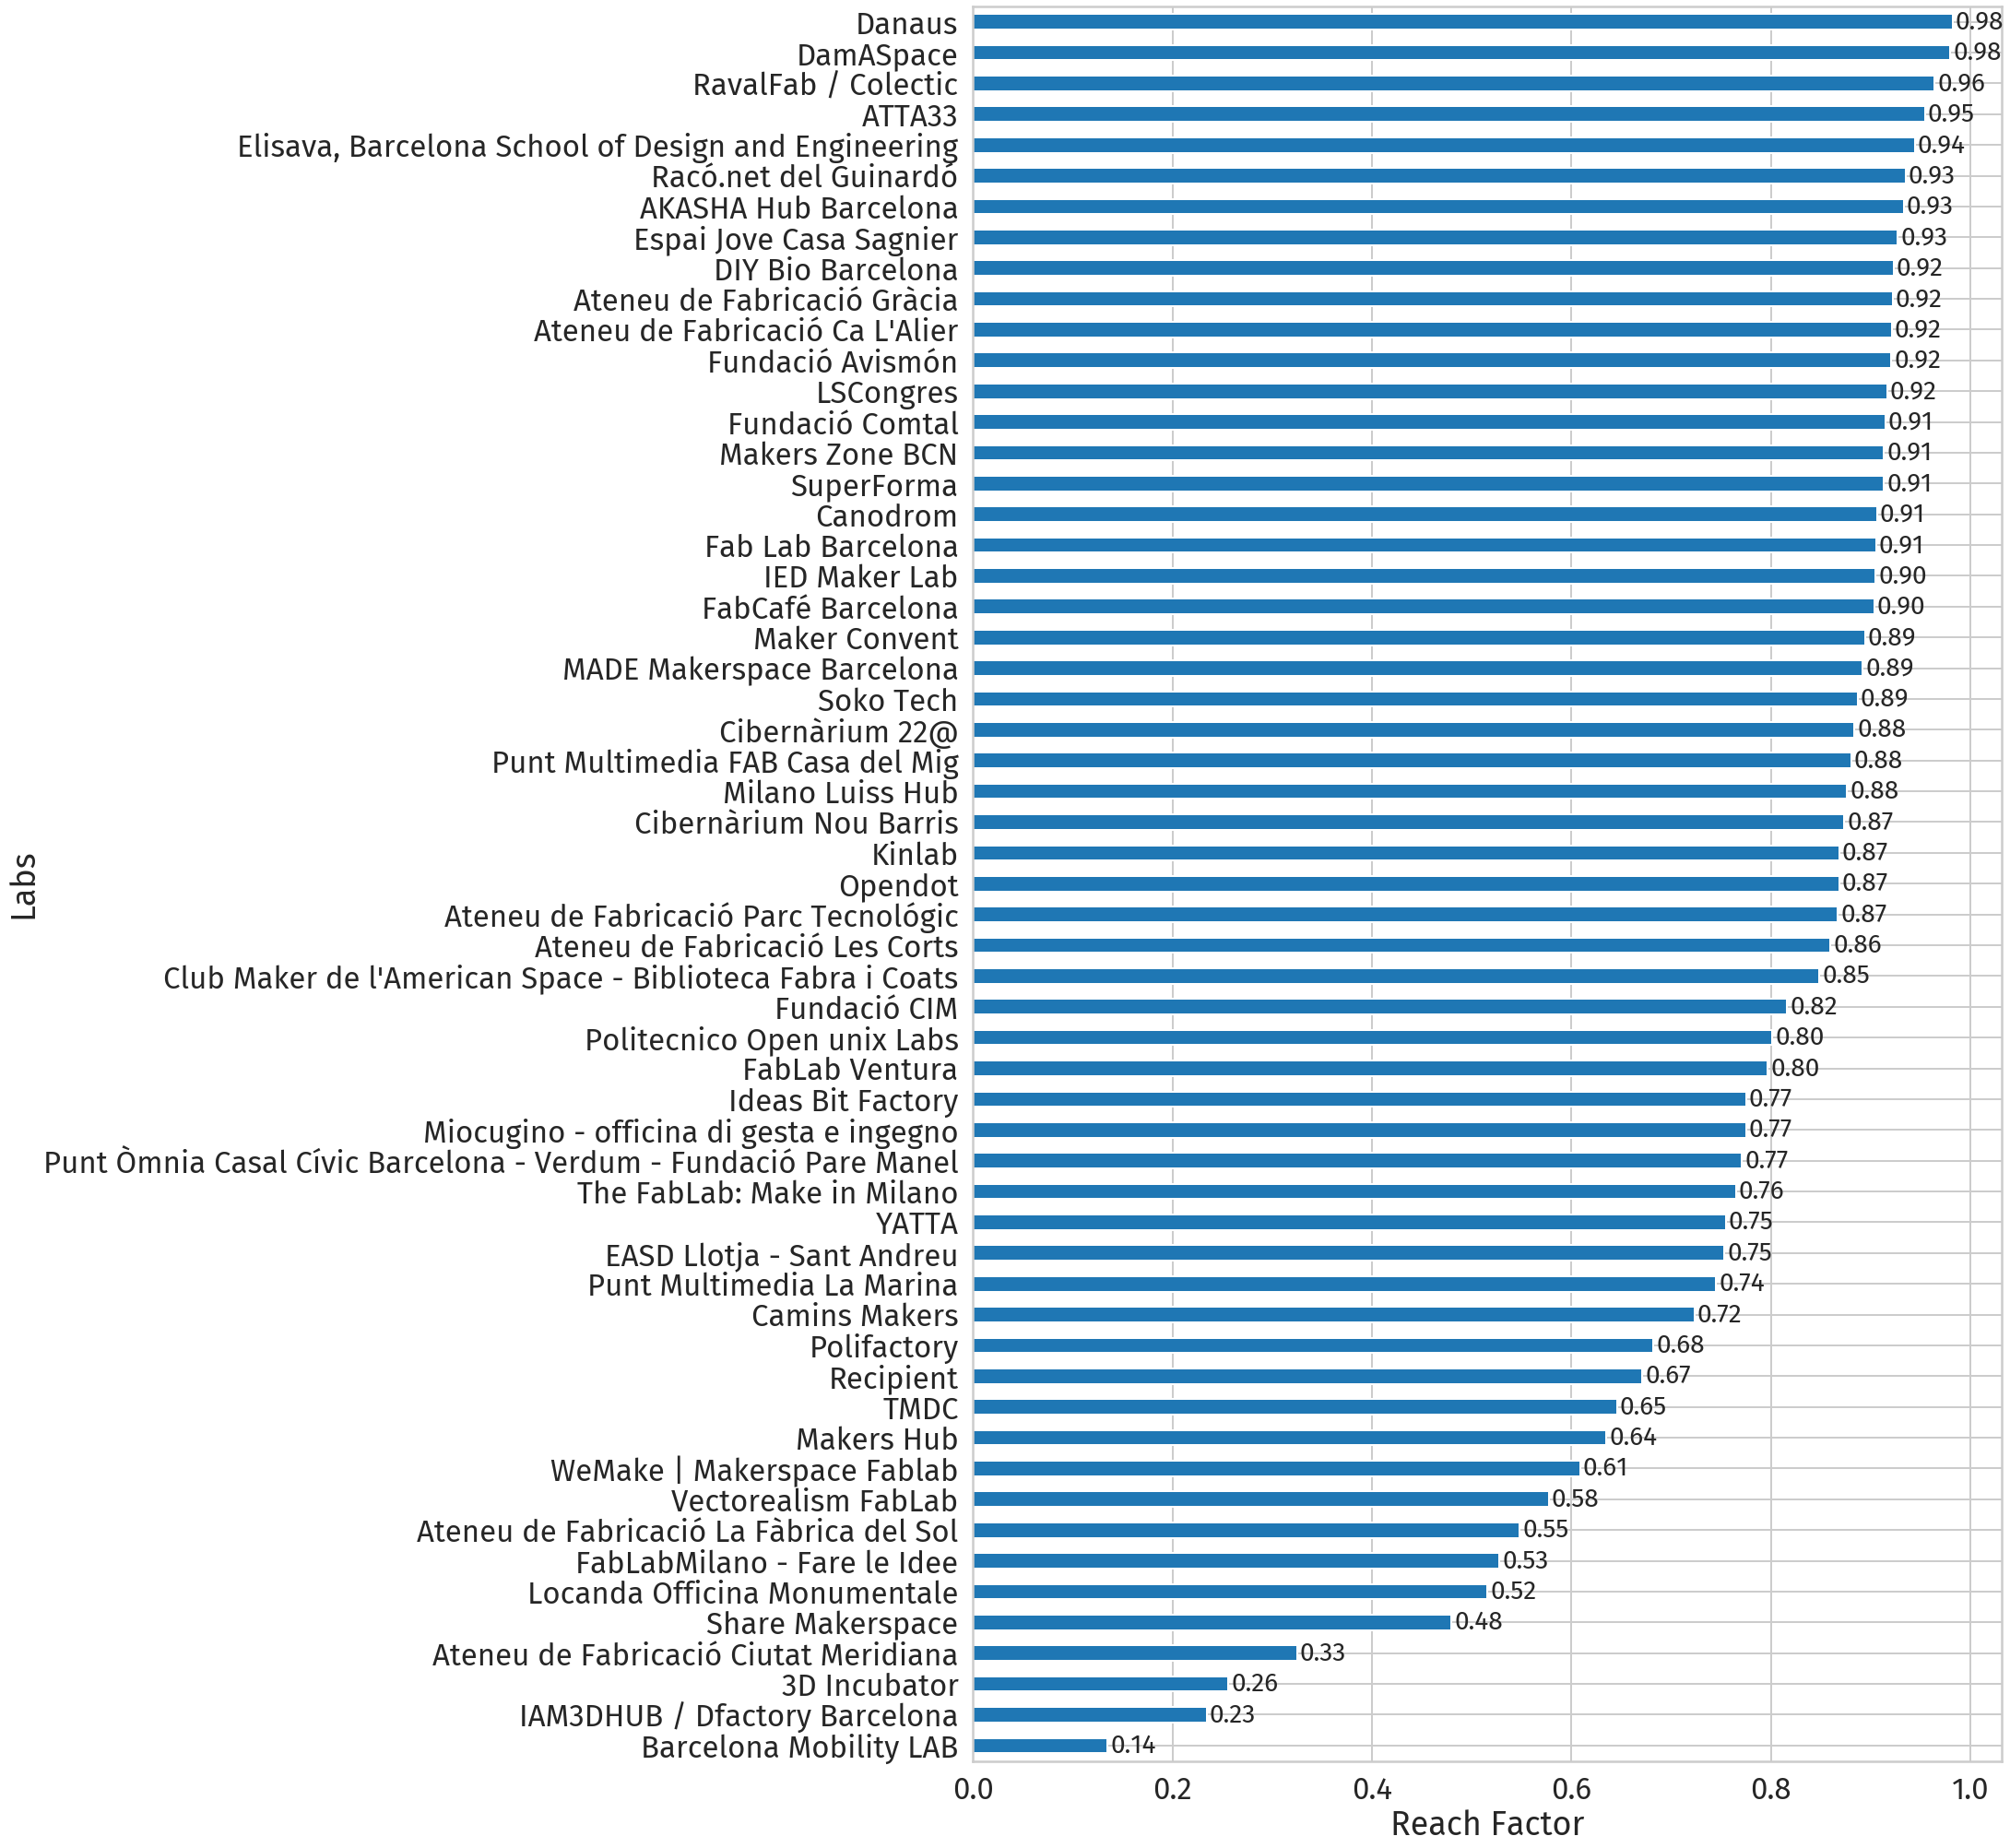

In [27]:
ax = map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind="barh", figsize=(20,35))
ax.bar_label(ax.containers[0], fmt="%.2f", size=28, padding=3)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_reachfactor_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_bar.png", dpi=300, bbox_inches="tight")

### Labs values clustered by city

In [28]:
full_map_data.groupby(["Cluster","Type"]).size()

Cluster  Type                         
BCN      Ateneu de Fabricació             6
         City Space                       6
         DIYBio Lab                       1
         Fab Lab                          6
         FabCafé                          1
         Foundation                       2
         Hackerspace                      2
         Incubator/Accelerator            4
         Library                          1
         Makerspace                       3
         Service                          1
         University + Industry R&D Lab    1
         University Lab                   4
MI       DIYBio Lab                       1
         Fab Lab                          6
         Hackerspace                      1
         Incubator/Accelerator            1
         Makerspace                       6
         Service                          3
         University Lab                   1
dtype: int64

In [29]:
full_map_data.groupby("Cluster")["total_pop"].sum()

Cluster
BCN    3018289.0
MI      725330.0
Name: total_pop, dtype: float64

In [30]:
full_map_data.groupby("Cluster")["total_pop"].describe()

count          mean           std      min      25%      50%  \
Cluster                                                                 
BCN       38.0  79428.657895  23930.348061  11587.0  77219.0  88885.0   
MI        19.0  38175.263158  14335.258843  11656.0  28070.5  39458.0   

             75%       max  
Cluster                     
BCN      94271.0  101992.0  
MI       48404.5   61851.0

In [31]:
full_map_data.groupby("Cluster")["area"].sum()

Cluster
BCN    149856740.6
MI      68088019.2
Name: area, dtype: float64

In [32]:
full_map_data.groupby("Cluster")["area"].describe()

count          mean           std         min          25%  \
Cluster                                                               
BCN       38.0  3.943598e+06  1.063282e+06   663848.58  3838327.200   
MI        19.0  3.583580e+06  7.065084e+05  2355878.41  3052342.685   

                 50%          75%         max  
Cluster                                        
BCN      4384776.075  4520540.205  4821324.40  
MI       3753146.090  4097185.200  4808370.81

In [33]:
full_map_data.groupby("Cluster")["reachfactor"].describe()

count      mean       std     min       25%      50%       75%  \
Cluster                                                                   
BCN       38.0  0.803379  0.216601  0.1352  0.781925  0.89325  0.920925   
MI        19.0  0.730042  0.143935  0.4799  0.621800  0.76460  0.834700   

            max  
Cluster          
BCN      0.9822  
MI       0.9796

plot the data

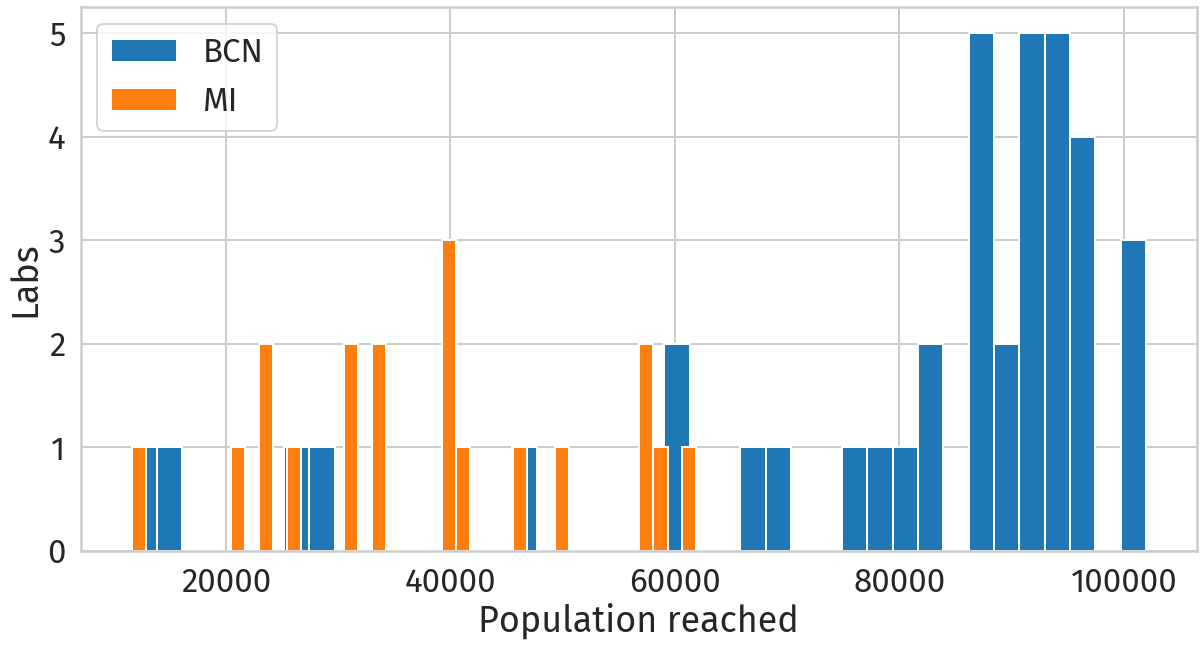

In [34]:
full_map_data.groupby("Cluster")["total_pop"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_population_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data for each lab

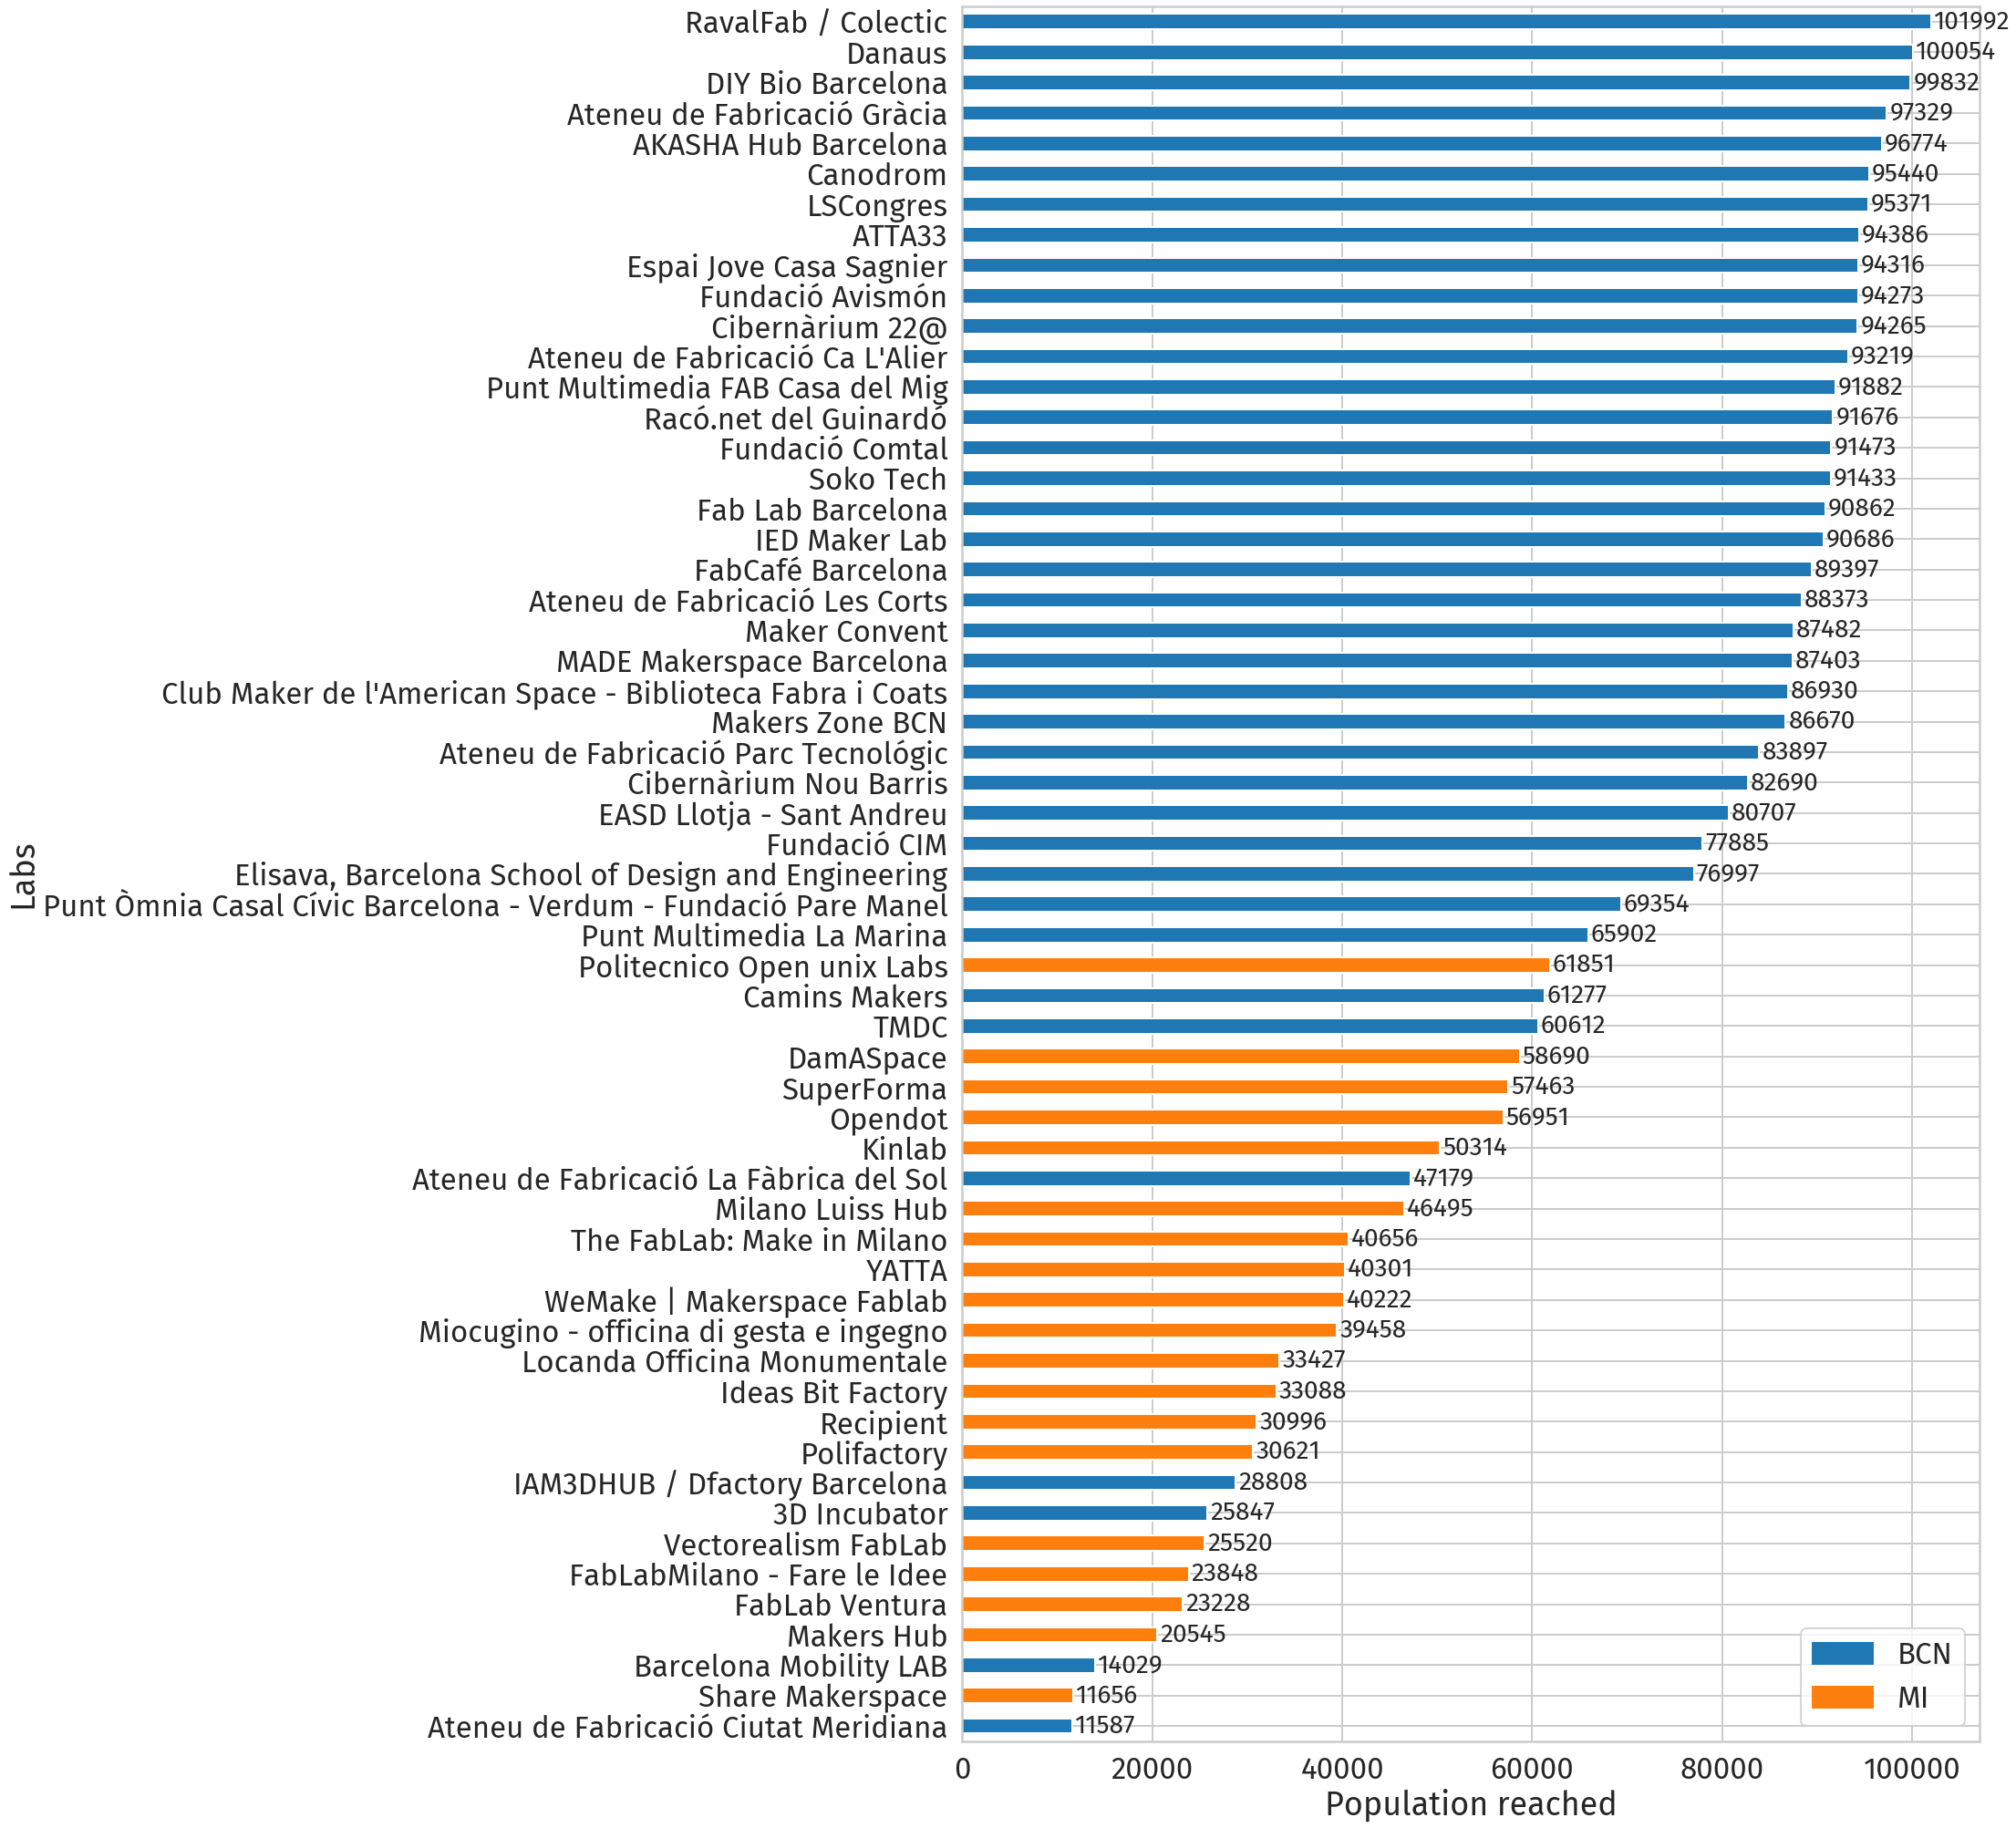

In [35]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['total_pop'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%d", size=28, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_population_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_bar.png", dpi=300, bbox_inches="tight")

plot the data

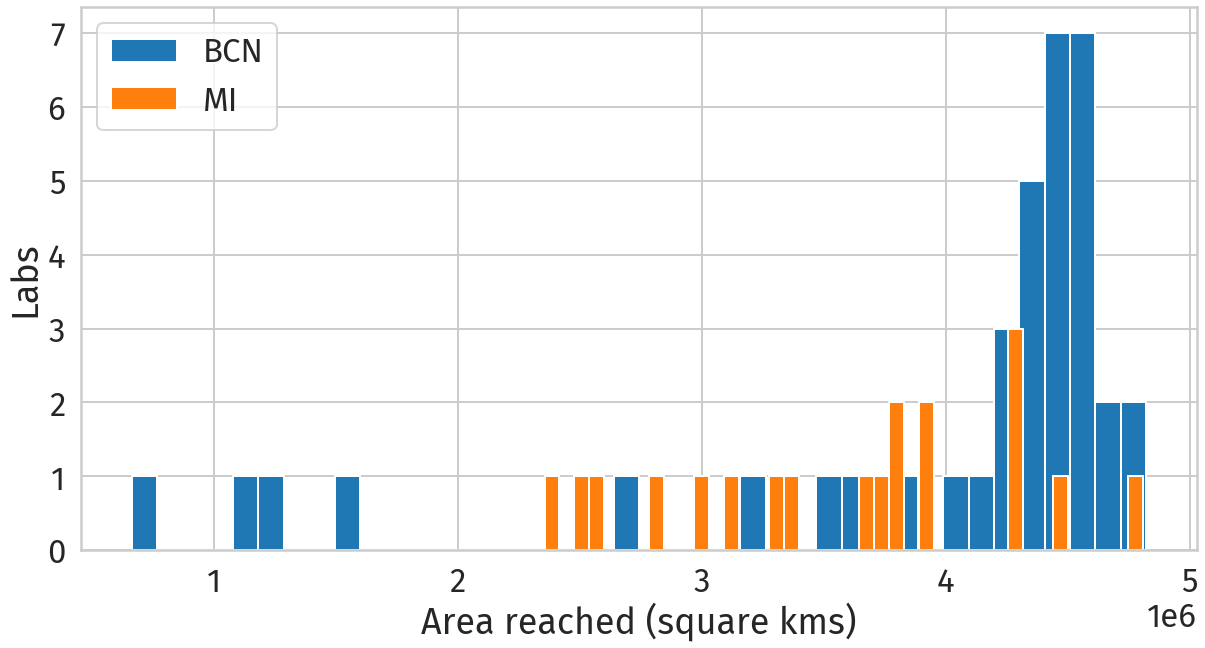

In [36]:
full_map_data.groupby("Cluster")["area"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Area reached (square kms)')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_area_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data 

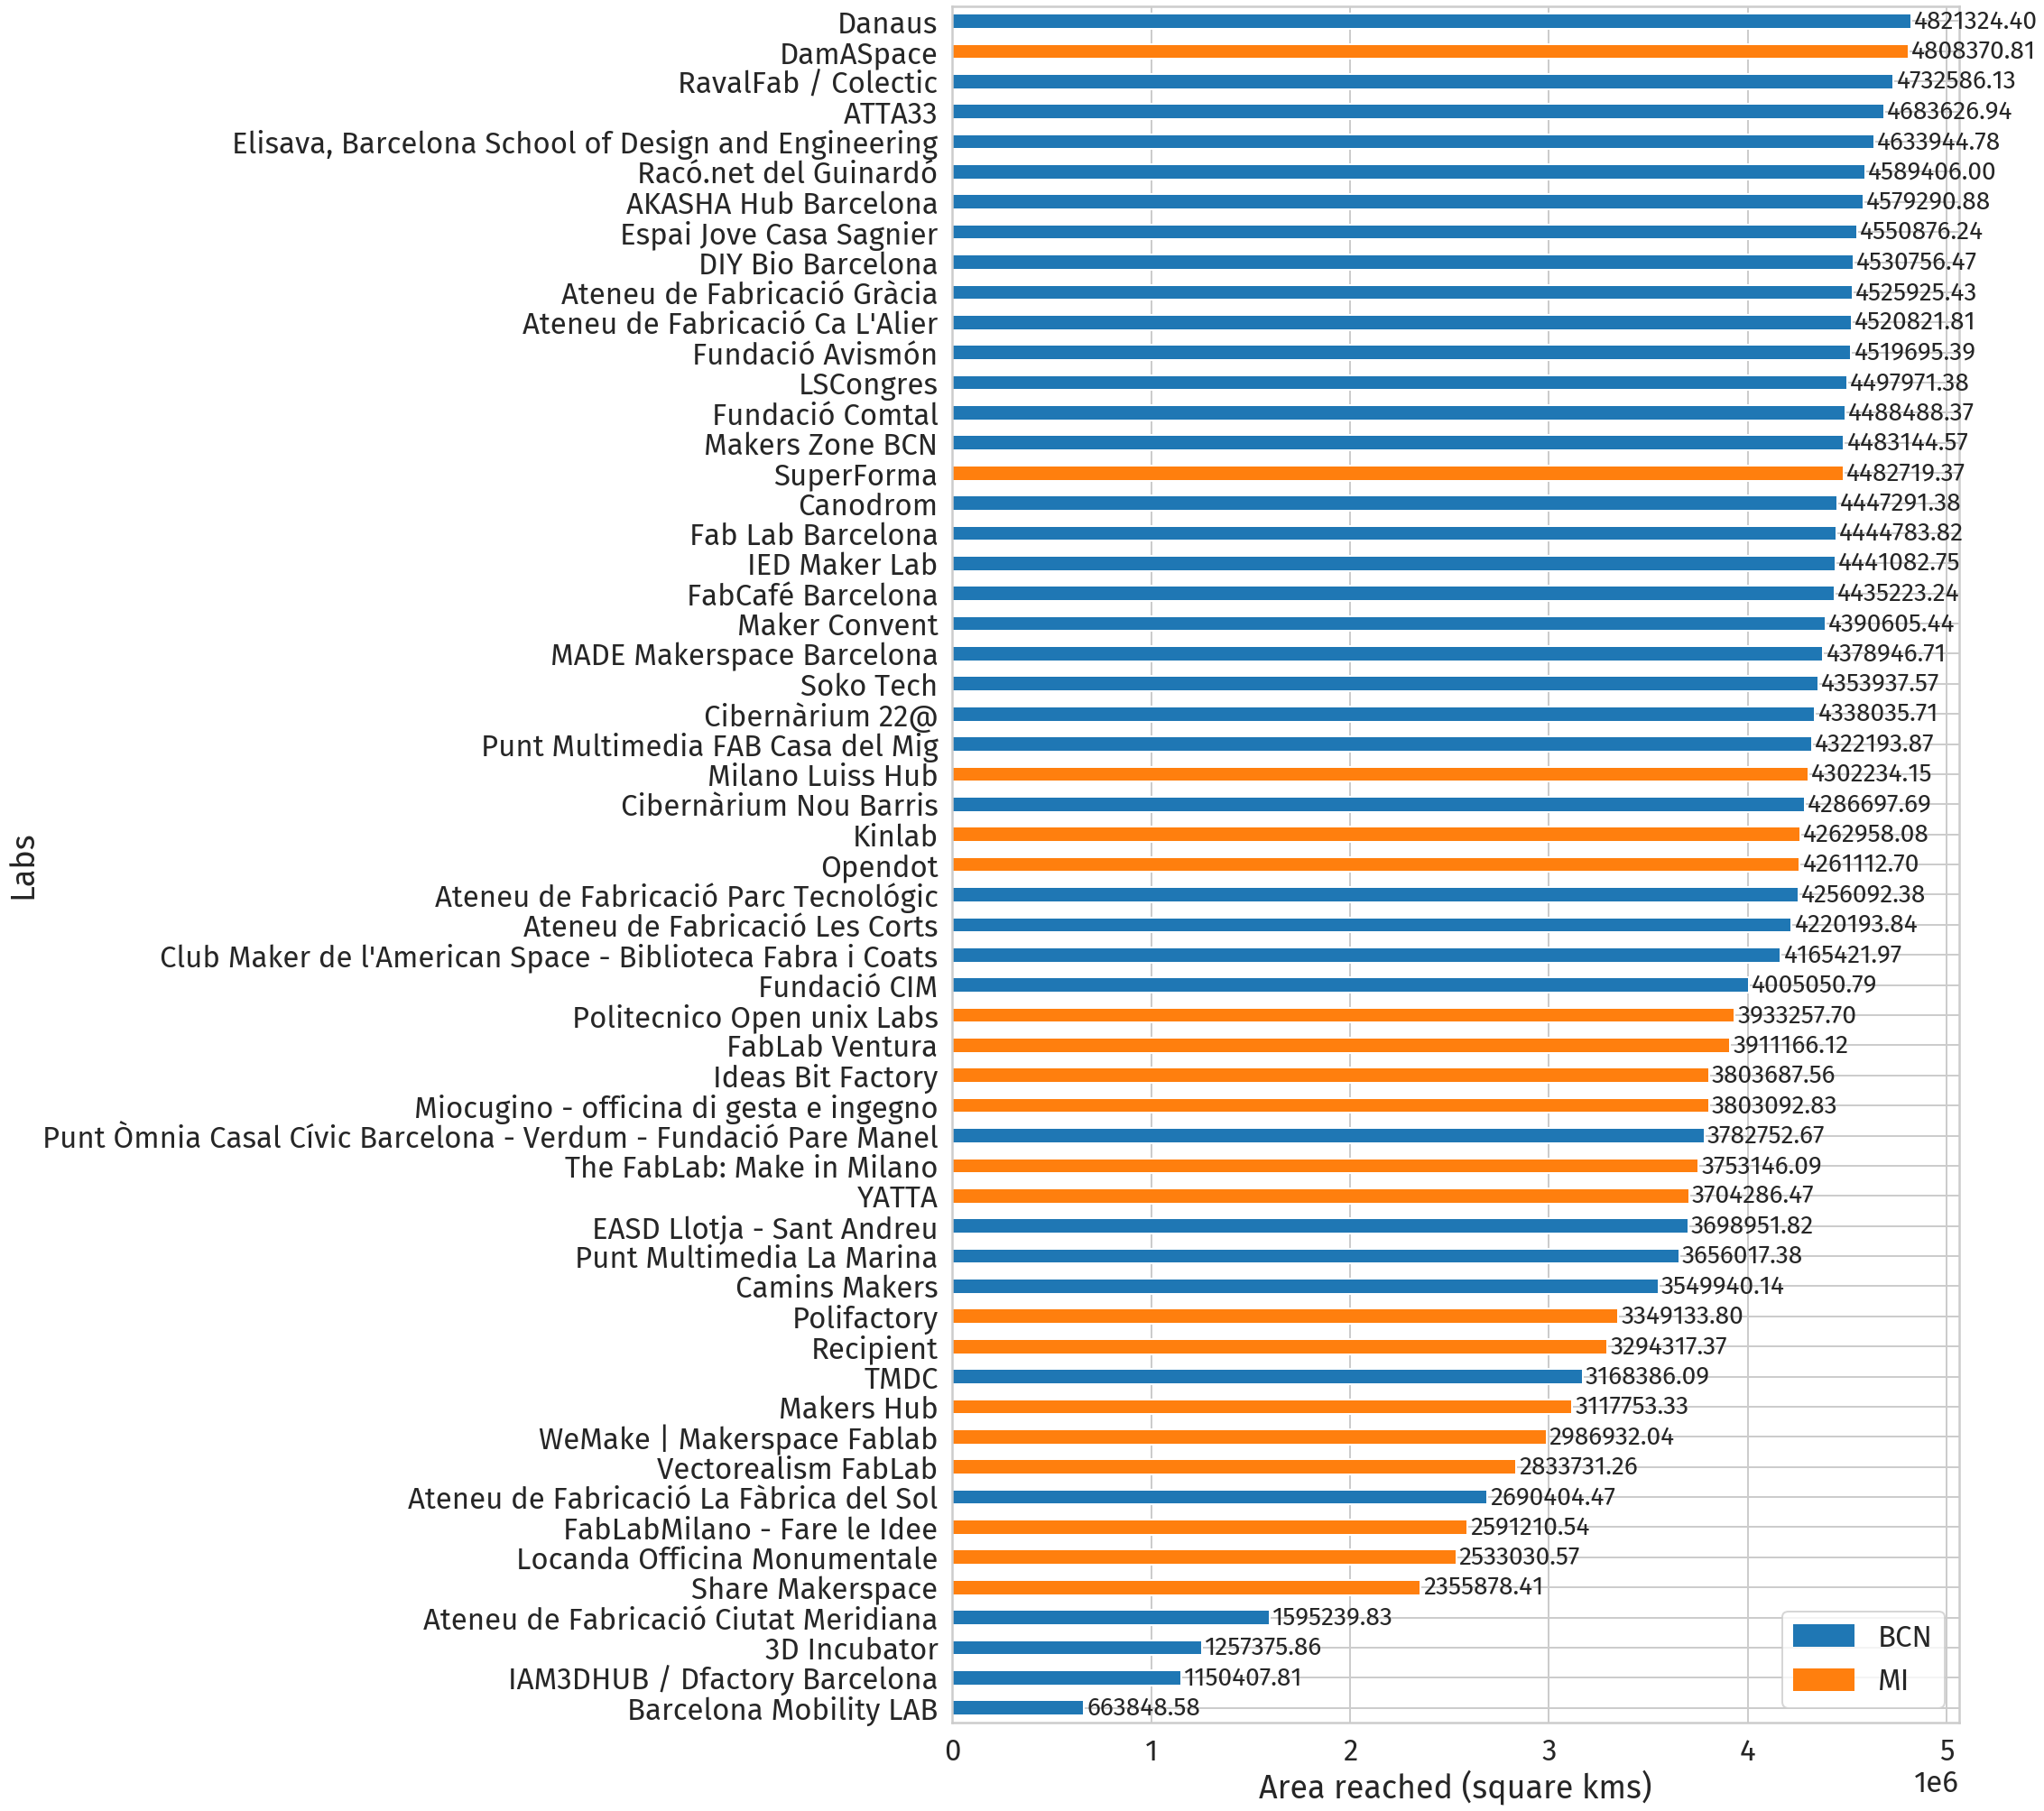

In [37]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['area'])['area'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['area'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=28, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Area reached (square kms)')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_area_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_bar.png", dpi=300, bbox_inches="tight")

plot the data

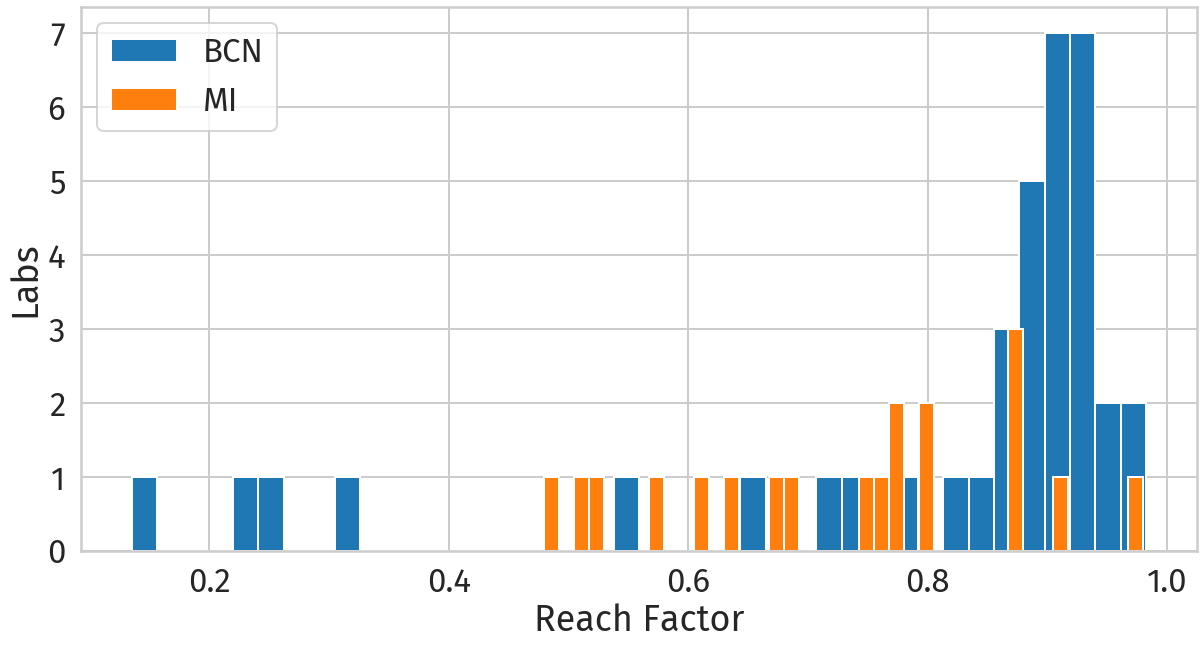

In [38]:
full_map_data.groupby("Cluster")["reachfactor"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data

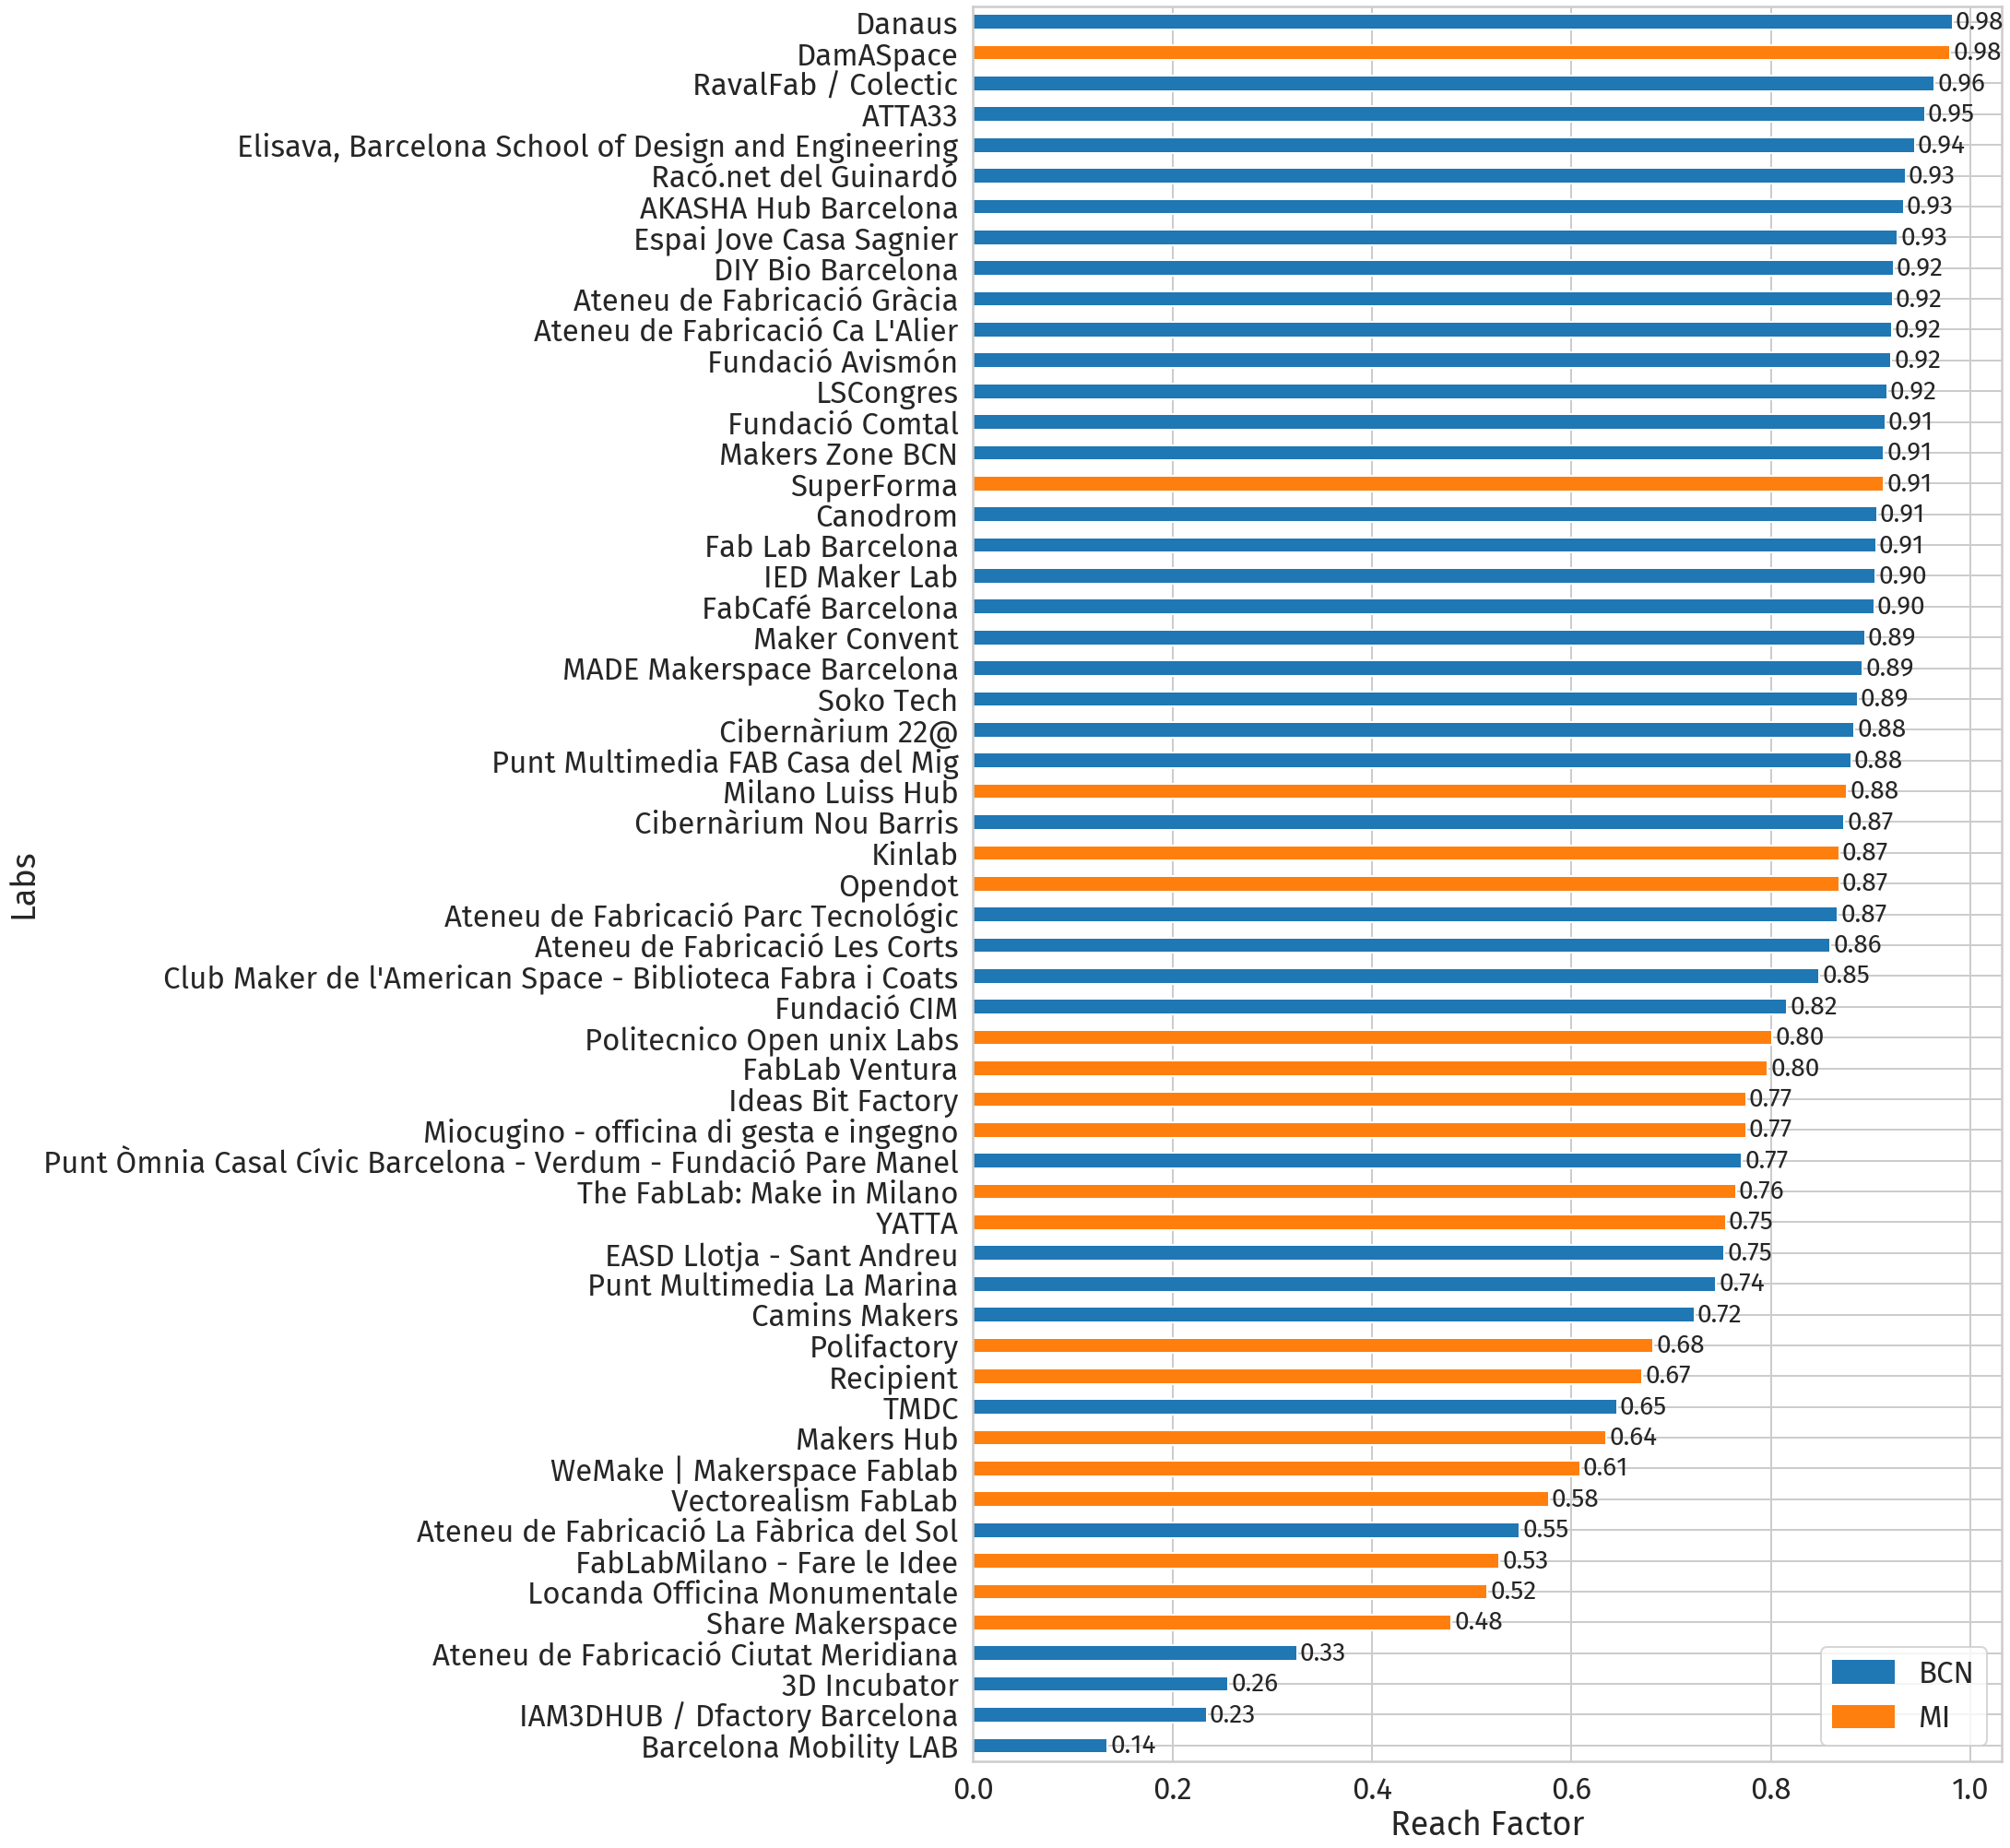

In [39]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['reachfactor'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=28, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_bar.png", dpi=300, bbox_inches="tight")

### Isochrones

create the map

In [40]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

In [41]:
for iso in data:
  folium.GeoJson(iso, name="geojson").add_to(m)
for loc in locations:
  #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
  folium.Circle(
    radius=30,
    location=[locations[loc][1],locations[loc][0]],
    popup=loc,
    tooltip=loc,
    color="crimson",
    fill="crimson",
).add_to(m)


show the map

red points = labs<Br/>
blu lines = isocrones 15' for each lab as center

In [42]:
folium.LayerControl().add_to(m)
m

save the web map

In [43]:
m.save("html" + os.sep + "city_isochrones.html")

### Isochrones with color from population reached

create the legend with a graduated color scale (yellow less, blu more)

In [44]:
linear = cmp.LinearColormap(
    ['yellow', 'green', 'blue'],
    vmin=map_data['total_pop'].min(), vmax=map_data['total_pop'].max(),
    caption='Total population'
)
linear

create the map

In [45]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

In [46]:
for iso in data:
  fillColor = map_data.loc[iso["name"]]["total_pop"]
  folium.GeoJson(iso, 
                 name="geojson", 
                 style_function=lambda feature: {
                     "fillColor": linear(feature["properties"]["total_pop"]),
                     "fillOpacity": 0.3,
                     "color": "gray",
                     "weight": 1,
                     "dashArray": ''
                     },
                 ).add_to(m)

for loc in locations:
    #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
    folium.Circle(
        radius=30,
        location=[locations[loc][1],locations[loc][0]],
        popup=loc,
        tooltip=loc,
        fill=True,
        color="crimson",
        fillColor="crimson"
    ).add_to(m)

folium.LayerControl().add_to(m)
m.add_child(linear)

save the map

In [47]:
m.save("html" + os.sep + "city_isochrones_popcolor.html")

add labels to the map

In [48]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

for iso in data:
  fillColor = map_data.loc[iso["name"]]["total_pop"]
  folium.GeoJson(iso, 
                 name="geojson", 
                 style_function=lambda feature: {
                     "fillColor": linear(feature["properties"]["total_pop"]),
                     "fillOpacity": 0.3,
                     "color": "gray",
                     "weight": 1,
                     "dashArray": ''
                     },
                 ).add_to(m)

for loc in locations:
    #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
    folium.Circle(
        radius=30,
        location=[locations[loc][1],locations[loc][0]],
        popup=loc,
        tooltip=loc,
        fill=True,
        color="crimson",
        fillColor="crimson"
    ).add_to(m)
    folium.map.Marker(
        [locations[loc][1] + 0.0, locations[loc][0] - 0.0],
        icon=folium.features.DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="background-color: rgba(255, 255, 255, 0.75); padding: 5px; font-size: 10px; font-family:'+'Fira Sans;'+'">'+loc+'</div>',
        )
    ).add_to(m)

folium.LayerControl().add_to(m)
m.add_child(linear)

save the map

In [49]:
m.save("html" + os.sep + "city_isochrones_popcolor_labels.html")